In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.fft import fft, fftfreq, fftshift
import scipy
import itertools
from ast import literal_eval
plt.style.use('Solarize_Light2')

In [0]:
%run ./nycmap_notebook

In [0]:
%run ./utils_stats_modeling

In [0]:
from shapely.geometry import Point, Polygon, shape
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.graphics.tsaplots as tsa
from sklearn.linear_model import LinearRegression
from sklearn import metrics
# ! pip install shapely

In [0]:
# File location and type
file_location = "/FileStore/tables/daily_citibike_demand_2013_06_to_2022_02.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

# display(df)
ride_df = df.toPandas()
ride_df['starttime'] = pd.to_datetime(ride_df['starttime'])
ride_df.set_index('starttime', inplace=True)
daily_rides = ride_df[['ride_count']].resample('1D').sum()
daily_rides['ride_count'] = daily_rides['ride_count'].replace(to_replace=0, method='bfill')

In [0]:
def neighborhood(point):
    for feature in nycmap['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['NTAName']
            continue
            
def borough(point):
    for feature in nycmap['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['BoroName']
            continue
            
def neighborhood_engin(df, neighborhood):
    neighborhood_df = df[df['neighborhood'] == neighborhood]
    neighborhood_daily = neighborhood_df[['ride_count']].resample('1D').sum()
    neighborhood_daily['ride_count'] = neighborhood_daily['ride_count'].replace(to_replace=0, method='bfill')
    return neighborhood_daily

def model_run(neighborhood_df_, df, neighborhood):
    order = neighborhood_df_.loc[neighborhood, 'order']
#     print(type(order))
    s_order = neighborhood_df_.loc[neighborhood, 'seasonal_order']
    mod = SARIMAX(df['ride_count_log'], order=order, seasonal_order=s_order).fit(maxiter=1000, disp=False)
    neighborhood_df_.loc[neighborhood, 'model'] = mod
    return neighborhood_df_

In [0]:
# Train/Test split
test_start = '2021-01-01'

In [0]:
# Finding list of all unique stations
df_unique = ride_df.drop_duplicates(subset='station_id') 
stations_df = df_unique[['station_id', 'lat', 'long']].reset_index().drop('starttime', axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2579 entries, 0 to 2578
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station_id  2578 non-null   float64
 1   lat         2579 non-null   float64
 2   long        2579 non-null   float64
dtypes: float64(3)
memory usage: 60.6 KB


In [0]:
# defining df columns
col_names = ['Latitude', 'Longitude', 'Borough', 'Neighborhood'] 
# defining  df
neighborhoods = pd.DataFrame(columns=col_names)

In [0]:
stations_df['point_coordinates'] = stations_df.apply(lambda row: Point(row['long'], row['lat']), axis=1)
stations_df.head()

/databricks/python/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:112: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  values = construct_1d_object_array_from_listlike(values)


station_id 
 lat 
 long 
 point_coordinates 
 
 
 
 
 0 
 72.0 
 40.767272 
 -73.993929 
 POINT (-73.99392888 40.76727216) 
 
 
 1 
 79.0 
 40.719116 
 -74.006667 
 POINT (-74.00666661 40.71911552) 
 
 
 2 
 82.0 
 40.711174 
 -74.000165 
 POINT (-74.00016545 40.71117416) 
 
 
 3 
 83.0 
 40.683826 
 -73.976323 
 POINT (-73.97632328 40.68382604) 
 
 
 4 
 116.0 
 40.741776 
 -74.001497 
 POINT (-74.00149746 40.74177603)

In [0]:
stations_df['neighborhood'] = stations_df['point_coordinates'].apply(lambda x: neighborhood(x))
stations_df['borough'] = stations_df['point_coordinates'].apply(lambda x: borough(x))

In [0]:
# Merging these dfs to the main df based on station_id
ride_df = ride_df.merge(stations_df, left_on='station_id', right_on='station_id', how='left').set_index(ride_df.index)
ride_df.drop(labels=['lat_y', 'long_y', 'point_coordinates'], axis=1, inplace=True)
ride_df.rename(columns={'lat_x': 'lat', 'long_x': 'long'}, inplace=True)

In [0]:
ride_df

station_id 
 lat 
 long 
 ride_count 
 year 
 time 
 neighborhood 
 borough 
 
 
 starttime 
 
 
 
 
 
 
 
 
 
 
 
 
 2013-06-01 
 72.0 
 40.767272 
 -73.993929 
 40 
 2013 
 2013-06-01 
 Clinton 
 Manhattan 
 
 
 2013-06-01 
 79.0 
 40.719116 
 -74.006667 
 61 
 2013 
 2013-06-01 
 SoHo-TriBeCa-Civic Center-Little Italy 
 Manhattan 
 
 
 2013-06-01 
 82.0 
 40.711174 
 -74.000165 
 6 
 2013 
 2013-06-01 
 Chinatown 
 Manhattan 
 
 
 2013-06-01 
 83.0 
 40.683826 
 -73.976323 
 32 
 2013 
 2013-06-01 
 Fort Greene 
 Brooklyn 
 
 
 2013-06-01 
 116.0 
 40.741776 
 -74.001497 
 53 
 2013 
 2013-06-01 
 Hudson Yards-Chelsea-Flatiron-Union Square 
 Manhattan 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 2022-02-28 
 8703.0 
 40.871420 
 -73.888390 
 1 
 2022 
 2022-02-28 
 Bedford Park-Fordham North 
 Bronx 
 
 
 2022-02-28 
 8715.0 
 40.872412 
 -73.912807 
 2 
 2022 
 2022-02-28 
 park-cemetery-etc-Manhattan 
 Manhattan 
 
 
 2022-02-28 
 8715.0 
 40.871390 
 -73.914318 
 1 
 2022 
 2022-02-28 
 park-cemetery-etc-Manhattan 
 Manhattan 
 
 
 2022-02-28 
 8738.0 
 40.873870 
 -73.895330 
 1 
 2022 
 2022-02-28 
 Van Cortlandt Village 
 Bronx 
 
 
 2022-02-28 
 8795.0 
 40.879350 
 -73.885340 
 1 
 2022 
 2022-02-28 
 Norwood 
 Bronx 
 
 
 
 2609269 rows × 8 columns

In [0]:
# creating a list of unique names of neighborhoods
neighborhood_names = ride_df['neighborhood'].unique()

In [0]:
neighborhood_dict = {}
for neighborhood in neighborhood_names:
    df = neighborhood_engin(ride_df, neighborhood)
    neighborhood_dict[neighborhood] = df

In [0]:
# weekly frequency downsampling as it had previously better performace for the aggrgated modeling
for neighborhood, df in neighborhood_dict.items():
    neighborhood_dict[neighborhood] = df[['ride_count']].resample('W-SAT').sum()

In [0]:
for neighborhood, df in neighborhood_dict.items():
    df['future'] = (df.index >= test_start).astype('int')
    neighborhood_dict[neighborhood] = df

In [0]:
# Generating a df for neighborhood results
neighborhood_df = pd.DataFrame(index=neighborhood_names, columns=['model', 'order', 'seasonal_order',
                                                            'explained_variance', 'MAE', 'MSE', 'R2',
                                                            '2021_actual', '2021_predicted', 'delta', 
                                                            'requires_log'])

In [0]:
for neighborhood, df in neighborhood_dict.items():

    neighborhood_df.loc[neighborhood, 'requires_log'] = True
    df['ride_count_log'] = df['ride_count'].apply(lambda x: np.log(x))
    neighborhood_dict[neighborhood] = df

In [0]:
#  Generating a df to store the forecastings from each neighborhood
neighborhood_df_pred = pd.DataFrame(index=neighborhood_dict['Clinton'][neighborhood_dict['Clinton'].index >= test_start].index, 
                              columns=neighborhood_names)

In [0]:
# Using our best model for the overal aggregated model for each neighborhood
for neighborhood, df in neighborhood_dict.items():
    neighborhood_df, neighborhood_df_pred = run_model(neighborhood_df, neighborhood_df_pred, neighborhood, df, 
                                    (1, 1, 0), (0, 1, 1, 52), 
                                    neighborhood_df.loc[neighborhood, 'requires_log'])


The python kernel is unresponsive.

In [0]:
neighborhood_df[neighborhood_df['R2'] < 0.25].shape

since there were many negiborhoods with low r2 we try to do a small grid search for each negiborhood seperatley to possibly improve the negiborhood level modeling

### Neighborhood Level Model Tunning: Grid Search

In [0]:
# Adding a df to save results of grid search
neighborhood_grid_search = pd.DataFrame(index=neighborhood_names, columns=['order', 's_order', 'ev'])

In [0]:
p = q = range(0, 2)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, [1], q))]

In [0]:
# Note: This cell takes time to run

# for neighborhood, df in neighborhood_dict.items():
#     neighborhood_grid_search = neighborhood_model_tune(pdq, seasonal_pdq, neighborhood, df, neighborhood_grid_search)

Becasue of very low configuration of DB community version I did the past few cells in a normal python environment and transfered theresults back here as csv files

In [0]:
# File location and type
file_location = "/FileStore/tables/results/df_preds.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df0 = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

# display(df)
neighborhood_df_pred = df0.toPandas()
neighborhood_df_pred.index = neighborhood_df_pred.starttime
# neighborhood_df_pred

In [0]:
# File location and type
file_location = "/FileStore/tables/results/neighborhood_grid_search2.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

# display(df)
neighborhood_grid_search = df.toPandas()

In [0]:
# File location and type
file_location = "/FileStore/tables/results/df_results.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df2 = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

# display(df2)
neighborhood_df = df2.toPandas()
neighborhood_df.index= neighborhood_df._c0

In [0]:
# File location and type
file_location = "/FileStore/tables/results/neighborhood_results2.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df3 = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

# display(df2)
final_results = df3.toPandas()
final_results.index= final_results._c0
final_results.dropna(how='any', inplace=True)
final_results['order'] = final_results['order'].apply(lambda x: literal_eval(x))
final_results['seasonal_order'] = final_results['seasonal_order'].apply(lambda x: literal_eval(x))

In [0]:
neighborhood_grid_search.dropna(how='any', inplace=True)
# changing format of order / s_orders columns from string to numbers and tupple by literal eval
neighborhood_grid_search['order'] = neighborhood_grid_search['order'].apply(lambda x: literal_eval(x))
neighborhood_grid_search['s_order'] = neighborhood_grid_search['s_order'].apply(lambda x: literal_eval(x))

##### Visualizing forecasting of neighborhoods with reletively better performance

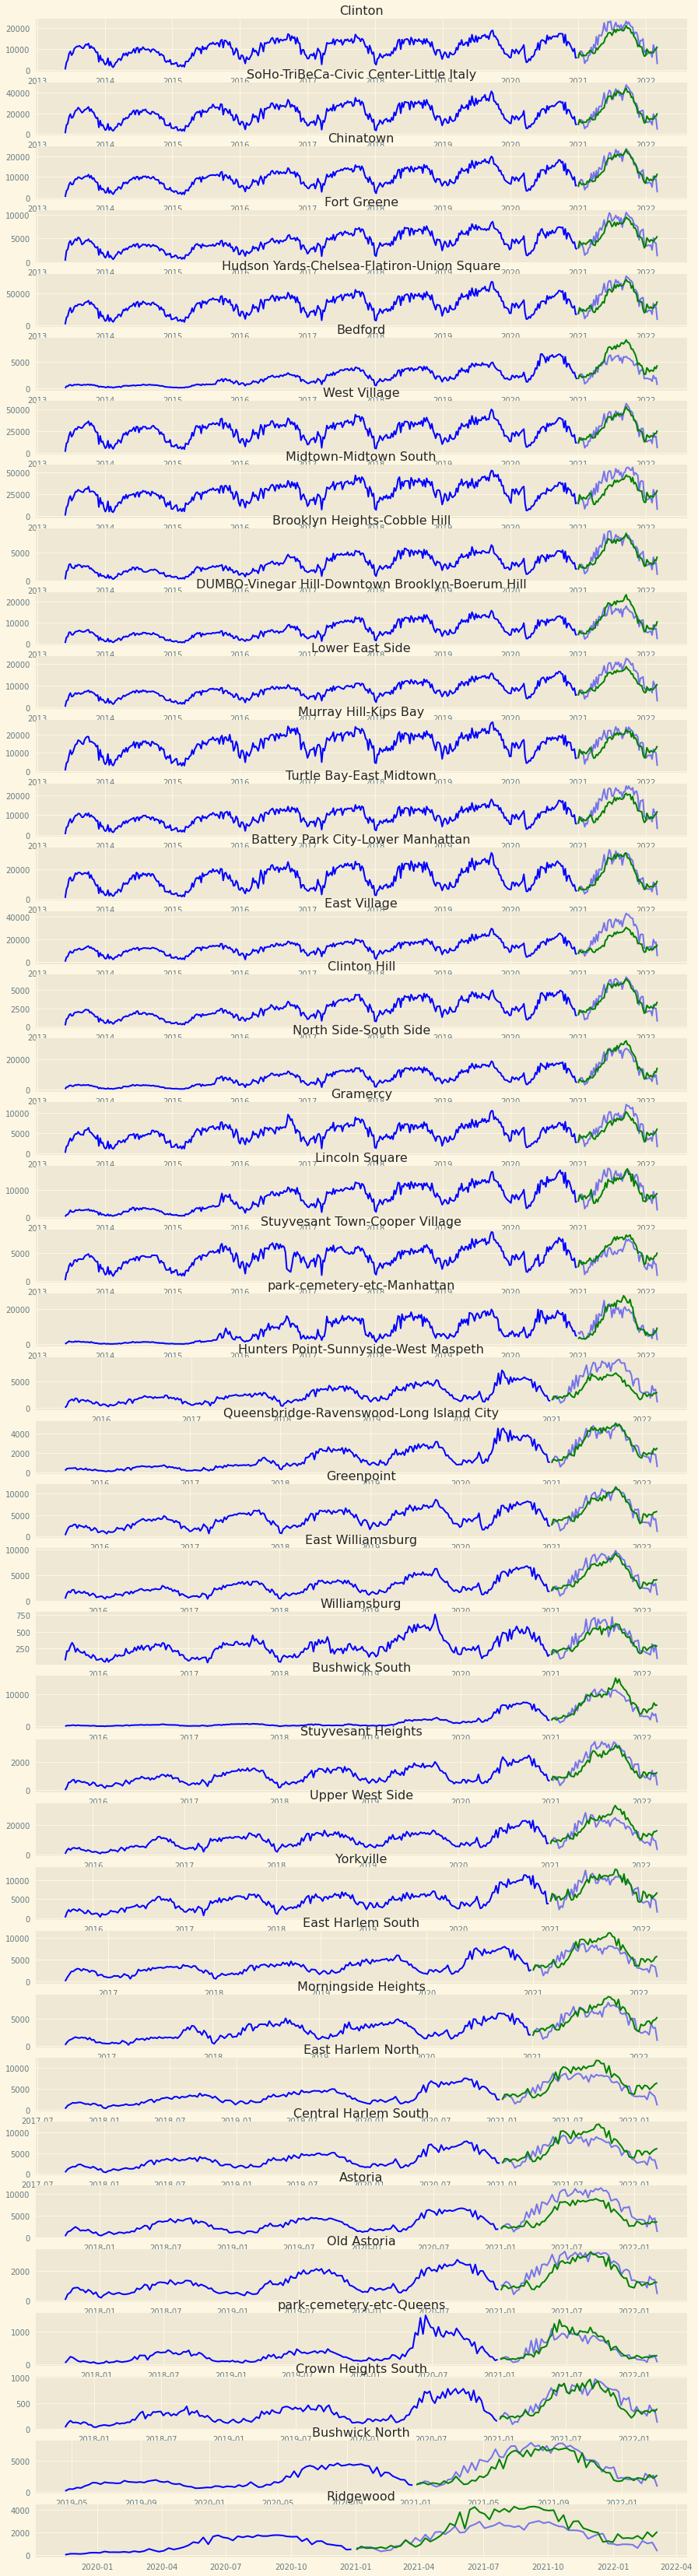

In [0]:
r2_threshold = 0.25
df_tune = neighborhood_df[neighborhood_df.loc[:,'R2'] > r2_threshold]

fig, ax = plt.subplots(nrows=(len(df_tune.index)), figsize=(15,60))
for i, neighborhood in enumerate(df_tune.index):
    ax[i].plot(neighborhood_dict[neighborhood].loc[neighborhood_dict[neighborhood].future == 0, 'ride_count'], color='blue')
    ax[i].plot(neighborhood_dict[neighborhood].loc[neighborhood_dict[neighborhood].future == 1, 'ride_count'], color='blue', 
               alpha=0.5)
    
    ax[i].plot(neighborhood_df_pred.loc[:,neighborhood], color='green')
    ax[i].set_title(neighborhood)

##### Visualizing forecasting of neighborhoods with poor performance

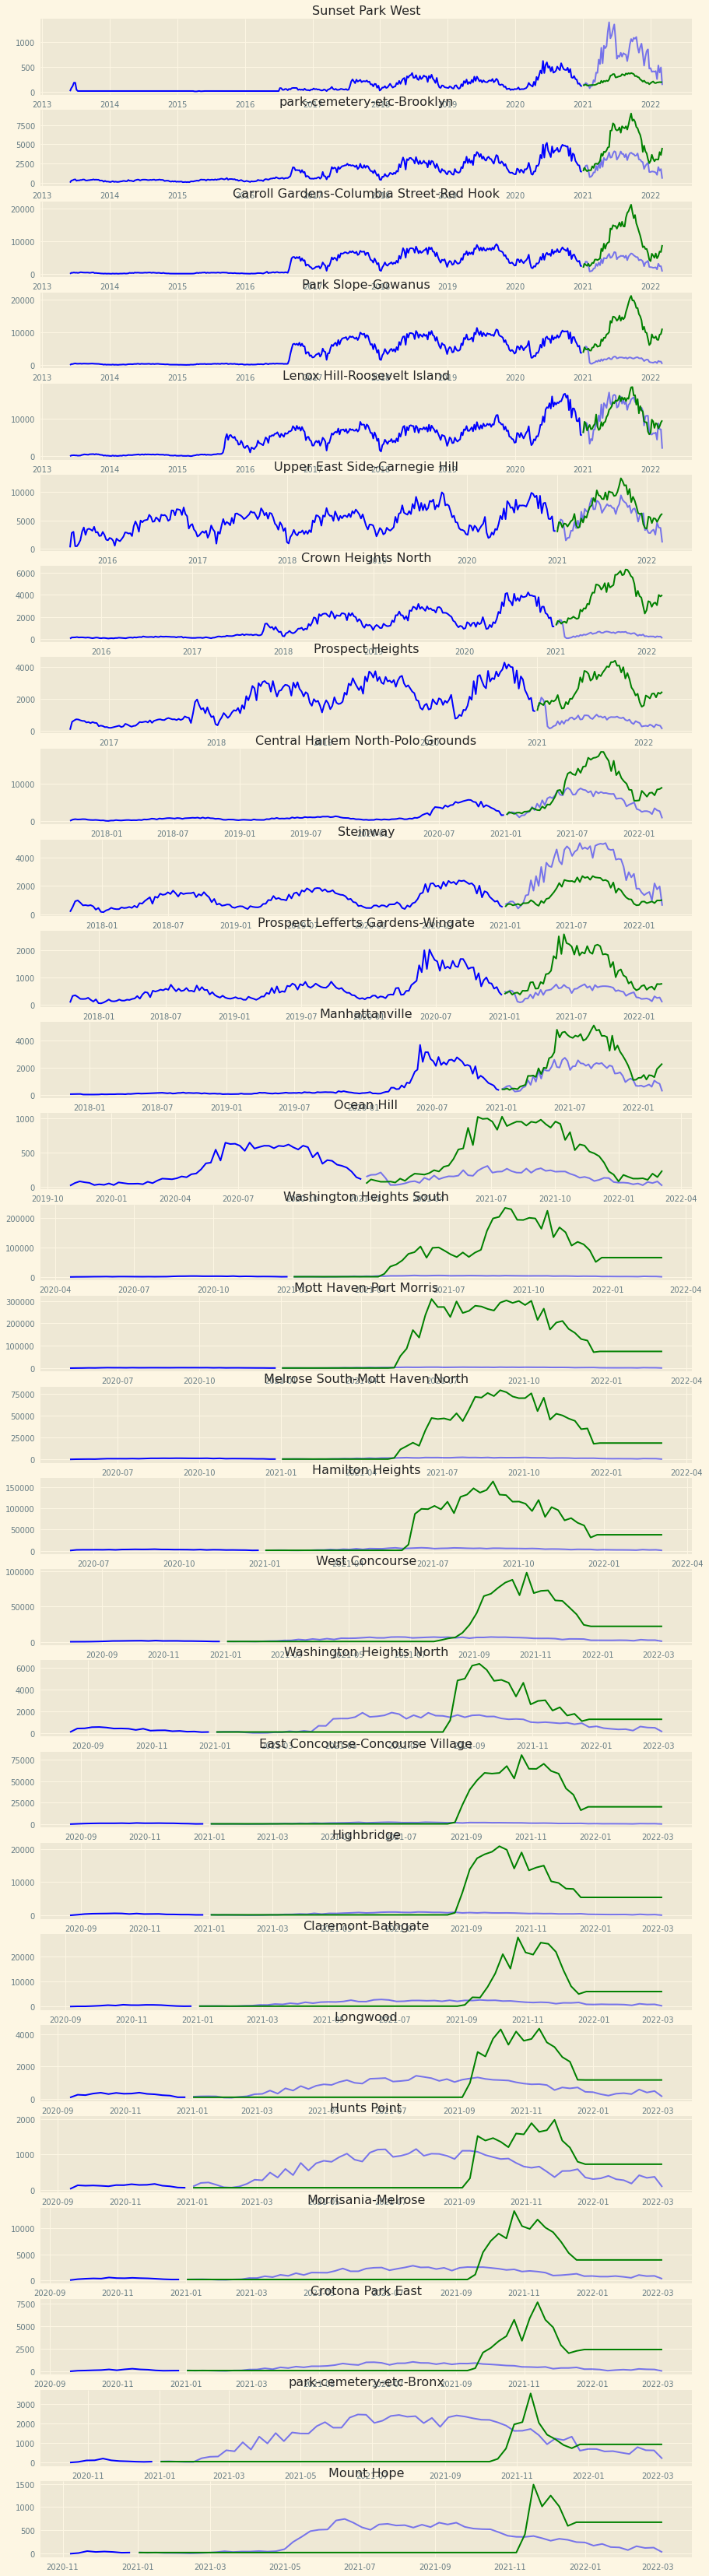

In [0]:
r2_threshold = 0.25
df_tune = neighborhood_df[neighborhood_df.loc[:,'R2'] < r2_threshold]

fig, ax = plt.subplots(nrows=(len(df_tune.index)), figsize=(15,60))
for i, neighborhood in enumerate(df_tune.index):
    ax[i].plot(neighborhood_dict[neighborhood].loc[neighborhood_dict[neighborhood].future == 0, 'ride_count'], color='blue')
    ax[i].plot(neighborhood_dict[neighborhood].loc[neighborhood_dict[neighborhood].future == 1, 'ride_count'], color='blue', 
               alpha=0.5)
    
    ax[i].plot(neighborhood_df_pred.loc[:,neighborhood], color='green')
    ax[i].set_title(neighborhood)

### Final Notes:
    - Grid searched improved the results
    - Initially there were around 88 neighborhoods available 
    - I exculded the neighborhoods with less than two years of historical data (69 neighborhoods left)
    - Around more than 41 of neighborhoods had very decent performance (r2 > 0.25)
    - around 28 of them had not very successful performance  (r2 < 0.25)
    - These are very decent results for the business objective
    - Given the 2020 data was significantly affected by lock down and covid